# Engagement outcomes

For the primary and some secondary outcomes, we need to use Google Analytics page views data:

**Primary outcome: Difference in the proportion of practices having their dashboard viewed during the 15 week intervention period, between intervention and control groups.** 

**Secondary: Change in practice dashboard views for all practices**
*This will be used to assess the global impact of the interventions, including access by non-intervention practices as a result of contamination and increased general awareness. This will be measured as change from baseline (15 weeks prior to first intervention) in the number of practices having their dashboard accessed, as a proportion of all practices, during the 15 week intervention period.*

## Analytics data extraction procedure:

 `Analytics - Behaviour - Site Content - All Pages`
 
 (this allows us to exclude specific measures accessed for individual practices, which may have been accessed from CCG pages)

 ```
 SEARCH: "/practice"
 DATE RANGE: 15 weeks from the date of WAVE1 (including date sent) and 15 weeks prior (2 separate downloads).
 SHOW ROWS: 5000
 ```
 
 Export as CSV

 Before importing, tidy up the csv to create a flat table
 (remove top and bottom groups of rows, convert numerical data to general format to remove commas)
 
### Time periods
 Start date: '2018-05-07' (note this is a BH so effectively next day is start)
 
- 5 weeks prior: '2018-04-02' - '2018-05-06'
- 15 weeks prior: '2018-01-22' - '2018-05-06' 
- wave 1: '2018-05-07' - '2018-06-10'
- wave 2: '2018-06-11' - '2018-07-15'
- wave 3: '2018-07-16' - '2018-08-19'

In [1]:
# Import page views data
import pandas as pd
import numpy as np
from ebmdatalab import bq
dfb = pd.read_csv('data/pageviews_20180122_20180506.csv',usecols={"Page","Pageviews","Unique Pageviews"} ) # before
dfa = pd.read_csv('data/pageviews_20180507_20180819.csv',usecols={"Page","Pageviews","Unique Pageviews"}, dtype={'Pageviews': np.int32}) # after

### Narrow down to practice dashboards only and extract practice code

# baseline data
dfb = dfb.rename(columns={'Page': 'practice_id'}) 
dfb = dfb.loc[dfb['practice_id'] != '/']          #remove any instances of root practice page
dfb = dfb.loc[dfb['practice_id'].str.len() == 17 ]  #limit to paths of at least 17 characters to exclude erroneous (too short) practice codes

# folllow-up data
dfa = dfa.rename(columns={'Page': 'practice_id'})
dfa = dfa.loc[dfa['practice_id'] != '/']
dfa = dfa.loc[dfa['practice_id'].str.len() == 17]

# extract practice code from path
dfb.practice_id = dfb.practice_id.str.replace('/practice', '')
dfa.practice_id = dfa.practice_id.str.replace('/practice', '')
dfb.practice_id = dfb.practice_id.str.replace('/', '')
dfa.practice_id = dfa.practice_id.str.replace('/', '')

dfa.sort_values(by="Unique Pageviews").reset_index(drop=True).head()

,practice_id,Pageviews,Unique Pageviews
0,L81080,2,1
1,F81047,1,1
2,F81051,1,1
3,F81076,1,1
4,F81078,1,1


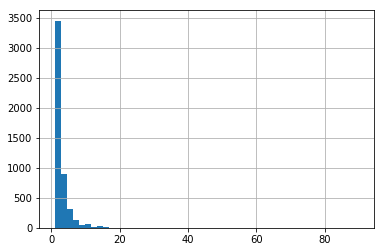

,Pageviews,Unique Pageviews
count,4954.000000,4954.000000
mean,3.165927,2.517562
std,4.412544,3.246237
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,4.000000,3.000000
max,107.000000,90.000000


In [2]:
import matplotlib.pyplot as plt

dfa['Unique Pageviews'].hist(bins=50)
plt.show()
dfa.describe()

### import allocated practices dataset and join to page views data

In [3]:
prac = pd.read_csv('data/practice_allocations.csv')

b = dfb.copy()
a = dfa.copy()

m = prac.merge(b, how='left', on='practice_id')
m2 = m.merge(a, how='left', on='practice_id',suffixes=("_before","_after"))
m2.allocation = m2.allocation.fillna('con') # replace NaNs in order to perform groupby on this field
m2['Unique Pageviews_before'] = m2['Unique Pageviews_before'].fillna(0)
m2['Unique Pageviews_after'] = m2['Unique Pageviews_after'].fillna(0)

m2.describe()

,Unnamed: 0,baseline,baseline_ranking,Pageviews_before,Unique Pageviews_before,Pageviews_after,Unique Pageviews_after
count,1401.000000,1401.000000,1401.000000,822.000000,1401.000000,852.000000,1401.000000
mean,700.000000,0.127044,0.900054,3.408759,1.512491,3.597418,1.649536
std,404.578175,0.022848,0.057765,3.910176,2.259272,4.102236,2.601500
min,0.000000,0.105085,0.800114,1.000000,0.000000,1.000000,0.000000
25%,350.000000,0.111336,0.850086,1.000000,0.000000,1.000000,0.000000
50%,700.000000,0.120265,0.900057,2.000000,1.000000,2.000000,1.000000
75%,1050.000000,0.134351,0.950029,4.000000,2.000000,4.000000,2.000000
max,1400.000000,0.323985,1.000000,41.000000,24.000000,53.000000,39.000000


## Baseline characteristics

In [4]:
q = '''
SELECT 
prac.code AS practice_id, 
prac.name,
ccg_id, 
total_list_size, 
CASE WHEN total_list_size < 3000 THEN 1 ELSE 0 END AS small_flag,
CASE WHEN gp_count =1 THEN 1 ELSE 0 END AS single_handed,
gp_count,
DATE_DIFF('2018-05-01', CAST (open_date AS DATE), YEAR) as open_years,
CASE WHEN d.dispensing_patients > 0 THEN 1 ELSE 0 END as dispensing,
--ru.rural_urban_code,
CASE WHEN ru.rural_urban_code IN (1,2) THEN 1 ELSE 0 END as rural,
CASE WHEN ru.rural_urban_code IN (5,6) THEN 1 ELSE 0 END as urban,
CAST(imd.value AS FLOAT64) AS imd,
ktt.numerator/ktt.denominator AS abx_per_starpu
    
from ebmdatalab.hscic.practices prac
INNER JOIN ebmdatalab.hscic.practice_statistics stat ON prac.code = stat.practice AND DATE(stat.month) = '2018-02-01'   -- latest month
LEFT JOIN ebmdatalab.bsa.dispensing_practices_feb_2018 d ON prac.code= d.practice_code
LEFT JOIN `ONS.practices_rural_urban` ru ON prac.code = ru.code
LEFT JOIN (SELECT area_code, value FROM `ebmdatalab.alex.indicators_GP_data` 
    where indicator_name = "Deprivation score (IMD 2015)" and Area_Type = "GP") imd ON prac.code = imd.area_code
LEFT JOIN (SELECT practice_id, SUM(numerator) as numerator, AVG(denominator) as denominator 
    FROM `ebmdatalab.measures.practice_data_ktt9_antibiotics`
    WHERE CAST(month AS date) between '2017-09-01' and '2018-02-01' group by practice_id) ktt ON prac.code = ktt.practice_id

WHERE 
prac.ccg_id NOT IN ('99P')  -- exclude any CCGs involved in preliminary testing
AND prac.code NOT IN ('')       -- exclude any practices involved in preliminary testing -- replace with [list of practices to exclude]
AND prac.setting = 4            -- include standard practices only
AND prac.status_code = 'A'      -- active status (exclude dormant and closed)

ORDER BY practice_id
'''

stats = bq.cached_read(q, csv_path='data/practice_baseline_data.csv')
stats.head()

,practice_id,name,ccg_id,total_list_size,small_flag,single_handed,gp_count,open_years,dispensing,rural,urban,imd,abx_per_starpu
0,A81001,THE DENSHAM SURGERY,00K,4104,0,0,2,44,0,0,0,29.140310,0.546062
1,A81002,QUEENS PARK MEDICAL CENTRE,00K,19990,0,0,13,44,0,0,0,29.689706,0.584170
2,A81004,BLUEBELL MEDICAL CENTRE,00M,10023,0,0,5,44,0,0,0,34.411828,0.569501
3,A81005,SPRINGWOOD SURGERY,00M,7981,0,0,6,44,0,0,0,15.743812,0.502996
4,A81006,TENNANT STREET MEDICAL PRACTICE,00K,14458,0,0,10,44,0,0,0,31.791515,0.590814


In [5]:
s2 = prac.merge(stats, on="practice_id",how="left")
s3 = s2.groupby("allocation").agg({"practice_id":"nunique", 
                              "total_list_size": "mean",
                              "small_flag": "mean",
                              "single_handed":"mean",
                              "gp_count":"mean",
                              "dispensing":"mean",  
                              "imd":"mean",
                              "abx_per_starpu":"mean",     
                              "baseline":"mean"})
s4 = s2.groupby("group_ab").agg({ "practice_id":"nunique", 
                              "total_list_size": "mean",
                              "small_flag": "mean",
                              "single_handed":"mean",
                              "gp_count":"mean",
                              "dispensing":"mean",
                              "imd":"mean",
                              "abx_per_starpu":"mean",
                              "baseline":"mean"})


s3.sort_index(ascending=False).append(s4.drop("con")).transpose()

,con,I,A,B
practice_id,698.000000,703.000000,356.000000,347.000000
total_list_size,8119.636501,8517.418675,8486.582353,8549.777778
small_flag,0.076923,0.081325,0.094118,0.067901
single_handed,0.066365,0.054217,0.055882,0.052469
gp_count,6.010558,6.234940,6.335294,6.129630
dispensing,0.205128,0.222892,0.223529,0.222222
imd,19.970076,19.859780,20.070249,19.638918
abx_per_starpu,0.504469,0.505787,0.504159,0.507496
baseline,0.127262,0.126829,0.127352,0.126291


## plot distribution of pageviews

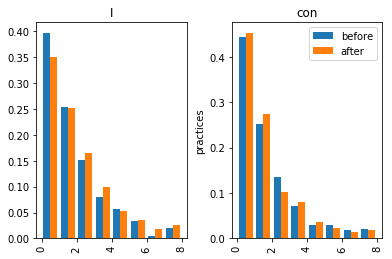

Unique Pageviews_before                                          \
                             count      mean       std  min  25%  50%  75%   
allocation                                                                   
I                            703.0  1.527738  2.055224  0.0  0.0  1.0  2.0   
con                          698.0  1.497135  2.449049  0.0  0.0  1.0  2.0   

                 Unique Pageviews_after                                     \
             max                  count      mean       std  min  25%  50%   
allocation                                                                   
I           14.0                  703.0  1.847795  2.886434  0.0  0.0  1.0   
con         24.0                  698.0  1.449857  2.263409  0.0  0.0  1.0   

                       
            75%   max  
allocation             
I           2.0  39.0  
con         2.0  17.0

In [6]:
import matplotlib.pyplot as plt

ax = m2[['Unique Pageviews_before','Unique Pageviews_after']].hist(by=m2['allocation'], density=True, bins=[0,1,2,3,4,5,6,7,8], label=["before","after"])

plt.legend(loc='upper right')
plt.ylabel("practices")
plt.show()

m2[['allocation','Unique Pageviews_before','Unique Pageviews_after']].groupby("allocation").describe()

No handles with labels found to put in legend.


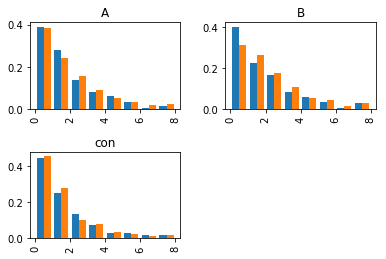

Unique Pageviews_before                                          \
                           count      mean       std  min  25%  50%  75%   
group_ab                                                                   
A                          356.0  1.410112  1.826351  0.0  0.0  1.0  2.0   
B                          347.0  1.648415  2.262478  0.0  0.0  1.0  2.0   
con                        698.0  1.497135  2.449049  0.0  0.0  1.0  2.0   

               Unique Pageviews_after                                          \
           max                  count      mean       std  min  25%  50%  75%   
group_ab                                                                        
A         13.0                  356.0  1.766854  2.856990  0.0  0.0  1.0  2.0   
B         14.0                  347.0  1.930836  2.918122  0.0  0.0  1.0  3.0   
con       24.0                  698.0  1.449857  2.263409  0.0  0.0  1.0  2.0   

                
           max  
group_ab        
A         33.0  
B         39.0  
con       17.0

In [7]:
ax = m2[['Unique Pageviews_before','Unique Pageviews_after']].hist(by=m2['group_ab'], density=True, bins=[0,1,2,3,4,5,6,7,8], label=["before","after"])

plt.legend(loc='upper right')
plt.ylabel("practices")
plt.show()

m2[['group_ab','Unique Pageviews_before','Unique Pageviews_after']].groupby("group_ab").describe()

### max-out top 1%

In [8]:

max_out = m2['Unique Pageviews_before'].quantile(0.99)
m2["proxy_pageviews_before"] = np.where(m2['Unique Pageviews_before']<max_out, m2['Unique Pageviews_before'], max_out)

max_out_b = m2['Unique Pageviews_after'].quantile(0.99)
m2["proxy_pageviews_after"] = np.where(m2['Unique Pageviews_after']<max_out_b, m2['Unique Pageviews_after'], max_out_b)

#m2["morethan1_pageviews_before"] = np.where(m2['Unique Pageviews_before']>1, 1,0)
#m2["morethan1_pageviews_after"] = np.where(m2['Unique Pageviews_after']>1, 1,0)

result = pd.DataFrame({'Unique Pageviews_after': m2["Unique Pageviews_after"].describe(),
                       'Unique Pageviews_before': m2["Unique Pageviews_before"].describe(),
                       'Proxy_pageviews_after': m2["proxy_pageviews_after"].describe(),
                       'Proxy_pageviews_before': m2["proxy_pageviews_before"].describe()
                      })

result


,Unique Pageviews_after,Unique Pageviews_before,Proxy_pageviews_after,Proxy_pageviews_before
count,1401.000000,1401.000000,1401.000000,1401.000000
mean,1.649536,1.512491,1.582441,1.477516
std,2.601500,2.259272,2.118073,2.039177
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000
max,39.000000,24.000000,10.000000,11.000000


# Primary engagement outcome #######################################################
## Difference in the proportion of practices having their dashboard viewed during the 15 week intervention period, between intervention and control groups. 


In [9]:

# define aggregations
aggregations = {
    'practice_id': { # work on the "practice_id" column
        'Count': 'count'},
    'Pageviews_before': {     
        'Distinct pages': 'count'},
    'Pageviews_after': {     
        'Distinct pages': 'count'},
    'proxy_pageviews_before': {
        'Mean': 'mean',
        'StDev': 'std',
        'Max': 'max',
        'Median': 'median'},
    'proxy_pageviews_after': {
        'Mean': 'mean',
        'StDev': 'std',
        'Max': 'max',
        'Median': 'median'}
}

# Perform groupby aggregation for intervention vs control
m3 = m2.reset_index()
m3 = m3.groupby(["allocation"]).agg(aggregations)

m3 = m3.rename(columns={'proxy_pageviews_before': 'Page Views per Page (Before)', 'Pageviews_after':'Pages viewed After','Pageviews_before':'Pages viewed Before','proxy_pageviews_after': 'Page Views per Page (After)','practice_id':'Practices'}) 
m3["Pages viewed Before","%"] = (100*m3['Pages viewed Before','Distinct pages']/m3['Practices','Count']).round(1)
m3["Pages viewed After","%"] = (100*m3['Pages viewed After','Distinct pages']/m3['Practices','Count']).round(1)
m3 = m3.sort_index(axis=1)

m4 = m3[['Practices','Pages viewed Before','Pages viewed After']].sort_index(ascending=False)
#m3["change from baseline"] = m3["follow-up"]["percent_viewed_follow-up"] - m3["baseline"]["percent_viewed_baseline"]


m4

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Practices Pages viewed Before                Pages viewed After  \
               Count                   % Distinct pages                  %   
allocation                                                                   
con              698                56.4            394               55.9   
I                703                60.9            428               65.7   

                           
           Distinct pages  
allocation                 
con                   390  
I                     462

### Statistical analysis

In [10]:
# Primary and secondary outcomes measured as proportions will be compared with confidence intervals (CIs) and chi-squared tests
from scipy.stats import chi2_contingency

s1 = pd.DataFrame(m4.iloc[:,[0,4]]).reset_index()
s1.columns = s1.columns.droplevel()
s1["Not viewed"] = s1["Count"]-s1["Distinct pages"]
obs = np.array(s1[["Distinct pages","Not viewed"]])
 
print(s1)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

def diffprop(obs):
    """
    `obs` must be a 2x2 numpy array.

    Returns:
    delta
        The difference in proportions
    ci
        The Wald 95% confidence interval for delta
    corrected_ci
        Yates continuity correction for the 95% confidence interval of delta.
    """
    n1, n2 = obs.sum(axis=1)
    prop1 = obs[0,0] / n1
    prop2 = obs[1,0] / n2
    delta = prop1 - prop2

    # Wald 95% confidence interval for delta
    se = np.sqrt(prop1*(1 - prop1)/n1 + prop2*(1 - prop2)/n2)
    ci = (delta - 1.96*se, delta + 1.96*se)

    # Yates continuity correction for confidence interval of delta
    correction = 0.5*(1/n1 + 1/n2)
    corrected_ci = (ci[0] - correction, ci[1] + correction)

    return delta, ci, corrected_ci

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d.astype(float).round(4), 'confidence intervals: ',ci1)


        Count  Distinct pages  Not viewed
0  con    698             390         308
1    I    703             462         241
chi2 =  13.8334246943 ; p =  0.000199750974886
difference in proportion:  -0.0984 confidence intervals:  (-0.14931737405842316, -0.04757111449044836)


# Secondary outcomes

## The primary outcome will also be compared between the BI (A) and plain (B) feedback groups.

In [11]:

# Perform groupby aggregation for intervention vs control
m5 = m2.loc[(m2.group_ab !="con")].reset_index() # exclude control group
m5 = m5.groupby(["group_ab"]).agg(aggregations)
#m3.columns = m3.columns.droplevel()


m5 = m5.rename(columns={'proxy_pageviews_before': 'Page Views per Page (Before)', 'Pageviews_after':'Pages viewed After','Pageviews_before':'Pages viewed Before','proxy_pageviews_after': 'Page Views per Page (After)','practice_id':'Practices'}) 
m5["Pages viewed Before","%"] = (100*m5['Pages viewed Before','Distinct pages']/m5['Practices','Count']).round(1)
m5["Pages viewed After","%"] = (100*m5['Pages viewed After','Distinct pages']/m5['Practices','Count']).round(1)
m5 = m5.sort_index(axis=1)
#m3["percent_viewed_morethanonce_baseline"] = m3.morethan1_pageviews_before/m3.total_practices
#m3["percent_viewed_morethanonce_follow-up"] = m3["morethan1_pageviews_after"]/m3.total_practices

m6 = m5[['Practices','Pages viewed Before','Pages viewed After']]
#m3["change from baseline"] = m3["follow-up"]["percent_viewed_follow-up"] - m3["baseline"]["percent_viewed_baseline"]


m6

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Practices Pages viewed Before                Pages viewed After  \
             Count                   % Distinct pages                  %   
group_ab                                                                   
A              356                61.2            218               62.4   
B              347                60.5            210               69.2   

                         
         Distinct pages  
group_ab                 
A                   222  
B                   240

### Statistical test

In [12]:
s2 = pd.DataFrame(m6.iloc[:,[0,4]]).reset_index()
s2.columns = s2.columns.droplevel()
s2["Not viewed"] = s2["Count"]-s2["Distinct pages"]
obs = np.array(s2[["Distinct pages","Not viewed"]])
 
print(obs)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d.astype(float).round(3), 'confidence intervals: ',ci1)


[[222 134]
 [240 107]]
chi2 =  3.315843356 ; p =  0.0686151066496
difference in proportion:  -0.068 confidence intervals:  (-0.13800452295738394, 0.0019102315996789299)


## Difference in the mean dashboard views per practice during the 15 week intervention period, for intervention versus control groups....

### Note: changed to change from baseline and using a regression model

In [13]:
print(m3[['Practices','Page Views per Page (Before)','Page Views per Page (After)']].round(2))
m7 = m2[['practice_id','allocation','Unique Pageviews_before','Unique Pageviews_after']]
#m4["change from baseline"] = m4["percent_viewed_follow-up"] - m4["percent_viewed_baseline"]

import statsmodels.formula.api as smf
data = m7
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Unique Pageviews_after"] ~ data["Unique Pageviews_before"] +intervention', data=data).fit()

lm.summary()


           Practices Page Views per Page (Before)                     \
               Count                          Max  Mean Median StDev   
allocation                                                             
I                703                         11.0  1.51    1.0  1.99   
con              698                         11.0  1.44    1.0  2.09   

           Page Views per Page (After)                     
                                   Max  Mean Median StDev  
allocation                                                 
I                                 10.0  1.75    1.0  2.12  
con                               10.0  1.42    1.0  2.11  


C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     data["Unique Pageviews_after"]   R-squared:                       0.073
Model:                                        OLS   Adj. R-squared:                  0.072
Method:                             Least Squares   F-statistic:                     55.00
Date:                            Thu, 06 Feb 2020   Prob (F-statistic):           1.01e-23
Time:                                    17:05:52   Log-Likelihood:                -3273.9
No. Observations:                            1401   AIC:                             6554.
Df Residuals:                                1398   BIC:                             6569.
Df Model:                                       2                                         
Covariance Type:                        nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0033      0.105      9.578      0.000       0.798       1.209
data["Unique Pageviews_before"]     0.2983      0.030     10.059      0.000       0.240       0.356
intervention                        0.3888      0.134      2.903      0.004       0.126       0.652
==============================================================================
Omnibus:                     1527.165   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           181043.209
Skew:                           5.158   Prob(JB):                         0.00
Kurtosis:                      57.726   Cond. No.                         6.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Difference in the mean dashboard views per practice during the 15 week intervention period, for BI group (A) versus plain feedback group (B).

In [14]:

print(m5[['Practices','Page Views per Page (Before)','Page Views per Page (After)']].round(2))
m8 = m2[['practice_id','group_ab','Unique Pageviews_before','Unique Pageviews_after']].loc[(m2.group_ab !="con")]
#m4["change from baseline"] = m4["percent_viewed_follow-up"] - m4["percent_viewed_baseline"]

import statsmodels.formula.api as smf
data = m8
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Unique Pageviews_after"] ~ data["Unique Pageviews_before"] +intervention', data=data).fit()

lm.summary()

         Practices Page Views per Page (Before)                     \
             Count                          Max  Mean Median StDev   
group_ab                                                             
A              356                         11.0  1.40    1.0  1.78   
B              347                         11.0  1.63    1.0  2.18   

         Page Views per Page (After)                     
                                 Max  Mean Median StDev  
group_ab                                                 
A                               10.0  1.66    1.0  2.12  
B                               10.0  1.84    1.0  2.12  


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     data["Unique Pageviews_after"]   R-squared:                       0.050
Model:                                        OLS   Adj. R-squared:                  0.047
Method:                             Least Squares   F-statistic:                     18.40
Date:                            Thu, 06 Feb 2020   Prob (F-statistic):           1.63e-08
Time:                                    17:05:52   Log-Likelihood:                -1724.2
No. Observations:                             703   AIC:                             3454.
Df Residuals:                                 700   BIC:                             3468.
Df Model:                                       2                                         
Covariance Type:                        nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.3271      0.166      7.983      0.000       1.001       1.654
data["Unique Pageviews_before"]     0.3119      0.052      6.017      0.000       0.210       0.414
intervention                        0.0897      0.213      0.421      0.674      -0.328       0.508
==============================================================================
Omnibus:                      877.911   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           128632.810
Skew:                           6.172   Prob(JB):                         0.00
Kurtosis:                      68.108   Cond. No.                         6.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---------------------------------------------------------------------

# "Clicks" analysis: Activity arising from each intervention 
### Number of practices accessing at least one link provided in the intervention, as a proportion of all practices contacted, for BI group (A) versus plain feedback group (B).
### Number of links accessed at least once as a proportion of all links delivered by each method of contact (email, fax, letter).
### Proportion of emails opened overall; and total number of links accessed from emails as a proportion of those opened, during the follow-up period, for intervention A versus B. 

### Google Analytics data extraction method:
```
Analytics - Behaviour - Site Content - All Pages

 
 INCLUDE Medium (post, email, fax) and Segment (wave 1/2/3)
 DATE RANGE: restricted (by use of segments) to 93 days from date of sending of 1st intervention)
```

before importing remember to tidy up the csv.

Note: 
A URL from an intervention, such as http://www.op2.org.uk/d/P07932 should redirect to something like https://openprescribing.net/practice/P07932/#measure1?utm_source=rct1&utm_campaign=wave1&utm_medium=email

In [15]:
campaign2 = pd.read_csv('data/pageviews_wave123.csv',usecols={"Page","Pageviews","Medium","Segment","Unique Pageviews","Avg. Time on Page","Bounce Rate"})

campaign2.head()

,Page,Medium,Segment,Pageviews,Unique Pageviews,Avg. Time on Page,Bounce Rate
0,/practice/L81004/,post - ktt9_cephalosporins,rct1 - wave 1,15,11,00:01:36,63.64%
1,/practice/L81004/,post - ktt9_cephalosporins,rct1 - wave2,0,0,00:00:00,0.00%
2,/practice/L81004/,post - ktt9_cephalosporins,rct1 - wave3,0,0,00:00:00,0.00%
3,/measure/ktt9_cephalosporins/,email,rct1 - wave 1,14,14,00:02:39,100.00%
4,/measure/ktt9_cephalosporins/,email,rct1 - wave2,9,8,00:00:50,100.00%


In [16]:
c = campaign2.copy()
c = c.loc[c['Page'].str.find('practice') !=-1]

# extract practice, wave and medium information:
n0 = c['Page'].str.find('practice')+len("practice/")
n1 = c['Medium'].str.find(' ')
c["n0"] = n0
n2 = c['Segment'].str.len()

# trim medium to reduce the options to 'post 'email' and 'fax'
c["medium"] = c.Medium.str[0:1]


c[['x','practice_id']] = c['Page'].str.split("practice/",expand=True)
c['practice_id'] = c['practice_id'].str[0:6]
#c["n0"]
c["wave"] = c["Segment"].str[-1].astype(int)

c = c[c['practice_id'] != ""].drop(["Medium","Segment","x","n0"], axis=1)

c.sort_values(by="Unique Pageviews").reset_index(drop=True).head(10)

### NB some lines appear with no data due to the way the report is produced in Analytics

c = c.loc[c["Pageviews"]>0]
browsing = c.copy() # for exploratory analysis later

# group by practice because some viewed multiple pages
c = c.groupby(["practice_id","wave","medium"])["Pageviews","Unique Pageviews"].sum().reset_index()
c.head()

,practice_id,wave,medium,Pageviews,Unique Pageviews
0,A81030,3,e,1,1
1,A83050,1,e,1,1
2,A83050,2,e,1,1
3,A83050,3,e,4,2
4,A84007,1,e,4,4


In [17]:
# Join to practice allocation data (note, practice_ids won't be unique in the resulting dataframe)

#First make sure there's a row for every possible practice-wave-medium combination:
# create a table with each possible wave and medium
w = pd.DataFrame(data={'wave':[1,2,3],'medium':['e','f','p']})
#cross-join with practice allocation table, to create all possible combinations
prac2 = pd.concat([prac] * len(w["wave"]), keys=w["wave"]).reset_index(level=1, drop=True).rename_axis('wave').reset_index()
prac2 = pd.concat([prac2] * len(w["medium"]), keys=w["medium"]).reset_index(level=1, drop=True).rename_axis('medium').reset_index()

# join on practice, wave and medium
c2 = prac2.merge(c, how='left', on=['practice_id','wave','medium'])
c2 = c2.fillna({'Pageviews':0,'Unique Pageviews':0})
c2.head()


,medium,wave,Unnamed: 0,practice_id,ccg_id,baseline,baseline_ranking,allocation,group_ab,Pageviews,Unique Pageviews
0,e,1,0,A83060,00D,0.110106,0.840377,I,A,0.0,0.0
1,e,1,2,A83050,00J,0.109578,0.836808,I,A,1.0,1.0
2,e,1,1,A83637,00J,0.106878,0.814963,con,con,0.0,0.0
3,e,1,3,A81040,00K,0.106930,0.815534,con,con,0.0,0.0
4,e,1,4,A84007,00L,0.107757,0.822530,I,A,4.0,4.0


In [18]:
# Identify which practices were successfully contacted: 
# load csv containing information which means of contact were sent to each practice and which were undelivered
# NB all null for letters.

cont = pd.read_csv('data/intervention_report_v2.csv',usecols={"practice_id","wave","method","sent","delivery_success"}).fillna(0)
cont = cont.rename(columns={"method":"medium"})
#cont.loc[cont.medium=="p","medium"] = "l" # replace "p" with "l"


'''
cont = cont.merge(success.reset_index(), on="practice_id", how="inner") # exclude practices with no successful contact
'''
results = c2.merge(cont,on=["practice_id","medium","wave"],how="left").fillna(0)
results.head()


,medium,wave,Unnamed: 0,practice_id,ccg_id,baseline,baseline_ranking,allocation,group_ab,Pageviews,Unique Pageviews,sent,delivery_success
0,e,1,0,A83060,00D,0.110106,0.840377,I,A,0.0,0.0,1.0,1.0
1,e,1,2,A83050,00J,0.109578,0.836808,I,A,1.0,1.0,1.0,1.0
2,e,1,1,A83637,00J,0.106878,0.814963,con,con,0.0,0.0,0.0,0.0
3,e,1,3,A81040,00K,0.106930,0.815534,con,con,0.0,0.0,0.0,0.0
4,e,1,4,A84007,00L,0.107757,0.822530,I,A,4.0,4.0,1.0,1.0


## chart
Summarise how many practices accessed a link after each wave according to whether they had prior dashboard views or had previously clicked on a link

In [19]:
r2 = results[["practice_id","group_ab","medium","wave","Unique Pageviews"]].loc[(results.group_ab!="con")&(results.sent>0)&(results.Pageviews>0)]
r2 = r2.merge(m2[["practice_id","Unique Pageviews_before"]], how="left", on="practice_id").sort_values(by=["wave","practice_id"])
r2["prior_views"] = "no prior views"
r2.loc[r2["Unique Pageviews_before"]>0,"prior_views"] = "prior views"
r2 = r2.drop("Unique Pageviews_before",axis=1).groupby(["practice_id","group_ab","medium","prior_views","wave"]).sum().unstack().reset_index(col_level=1)
r2.columns = r2.columns.droplevel()

r3 = r2.copy()

# wave 1
r3.loc[(r3["prior_views"] =="prior views")&(r3[1].fillna(0)>0),"wave_1"] = "prior views"
r3.loc[(r3["prior_views"] =="no prior views")&(r3[1].fillna(0)>0),"wave_1"] = "no prior clicks"

# wave 2
r3.loc[(r3["prior_views"] =="prior views")&(pd.notnull(r3[2])),"wave_2"] = "prior views"
r3.loc[(r3["prior_views"] =="no prior views")&(r3[1].fillna(0)==0)&(pd.notnull(r3[2])),"wave_2"] = "no prior clicks"
r3.loc[(r3["prior_views"] =="no prior views")&(pd.notnull(r3[1]))&(pd.notnull(r3[2])),"wave_2"] = "prior click"

# wave 3
r3.loc[(r3["prior_views"] =="prior views")&(pd.notnull(r3[3])),"wave_3"] = "prior views"
r3.loc[(r3["prior_views"] =="no prior views")&(r3[1].fillna(0)+r3[2].fillna(0)==0)&(pd.notnull(r3[3])),"wave_3"] = "no prior clicks"
r3.loc[(r3["prior_views"] =="no prior views")&(pd.notnull(r3[1]))&(pd.notnull(r3[3])),"wave_3"] = "prior click"


r3.head(10)



wave,practice_id,group_ab,medium,prior_views,1,2,3,wave_1,wave_2,wave_3
0,A81030,A,e,prior views,NaN,NaN,1.0,NaN,NaN,prior views
1,A83050,A,e,no prior views,1.0,1.0,2.0,no prior clicks,prior click,prior click
2,A84007,A,e,prior views,4.0,NaN,NaN,prior views,NaN,NaN
3,A86020,A,e,no prior views,3.0,NaN,3.0,no prior clicks,NaN,prior click
4,A89007,A,e,prior views,1.0,NaN,NaN,prior views,NaN,NaN
5,B81099,A,f,prior views,NaN,7.0,NaN,NaN,prior views,NaN
6,B81656,A,f,prior views,2.0,NaN,NaN,prior views,NaN,NaN
7,B82042,B,p,prior views,NaN,1.0,NaN,NaN,prior views,NaN
8,B82049,B,p,prior views,1.0,NaN,NaN,prior views,NaN,NaN
9,B83056,A,e,prior views,NaN,3.0,NaN,NaN,prior views,NaN


### Summary data by group A/B and by wave

In [20]:
a = pd.DataFrame(r3.groupby("group_ab")["wave_1"].value_counts())
b = pd.DataFrame(r3.groupby("group_ab")["wave_2"].value_counts())
c = pd.DataFrame(r3.groupby("group_ab")["wave_3"].value_counts())
r4 = pd.concat([a,b,c], axis=1, join_axes=[b.index]).fillna(0).transpose()
data = r4.transpose().unstack().stack(level=0).swaplevel().reset_index()
r4.astype(int).transpose()


wave_1  wave_2  wave_3
group_ab wave_2                                 
A        prior views          39      16      17
         no prior clicks      19      11       8
         prior click           0       5       5
B        prior views          34      23      14
         no prior clicks      17      10       5
         prior click           0       1       2

### Summary data by method of contact and by wave

In [21]:
a = pd.DataFrame(r3.groupby("medium")["wave_1"].value_counts())
b = pd.DataFrame(r3.groupby("medium")["wave_2"].value_counts())
c = pd.DataFrame(r3.groupby("medium")["wave_3"].value_counts())
r5 = pd.concat([a,b,c], axis=1, join_axes=[b.index]).fillna(0).transpose()
data2 = r5.transpose().unstack().stack(level=0).reset_index()
r5.astype(int).transpose()

wave_1  wave_2  wave_3
medium wave_2                                 
e      prior views          45      27      19
       no prior clicks      19       8       8
       prior click           0       4       7
f      no prior clicks       6       8       3
       prior views          13       5       5
       prior click           0       1       0
p      prior views          15       7       7
       no prior clicks      11       5       2
       prior click           0       1       0

### Summary data by group A/B and medium (wave 1 only)

In [22]:
a = pd.DataFrame(r3.groupby(["group_ab","medium"])["wave_1"].count())

a

wave_1
group_ab medium        
A        e           35
         f           11
         p           12
B        e           29
         f            8
         p           14

### Create chart

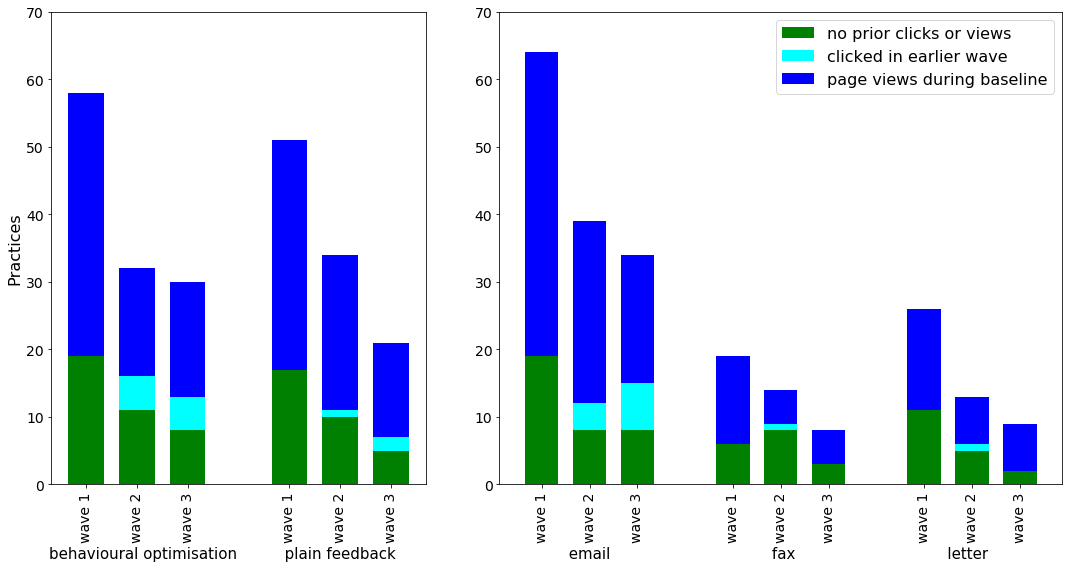

In [23]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


fig = plt.subplots(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3]) 

ax0 = plt.subplot(gs[0])
#ax1 = plt.subplot(1,2,1)

ind = np.r_[ 0:3, 4:7 ]     # the x locations for the groups
width = 0.7       # the width of the bars

p1 = plt.bar(ind, data["no prior clicks"], width, color='green')
p2 = plt.bar(ind, data["prior click"], width, bottom=data["no prior clicks"], color='cyan')
p3 = plt.bar(ind, data["prior views"], width, bottom=data["no prior clicks"]+data["prior click"], color='blue')

plt.ylabel('Practices', size=16)
plt.yticks(np.arange(0, 80, 10),size=14)

plt.xticks(ind, ('wave 1', 'wave 2', 'wave 3','wave 1', 'wave 2', 'wave 3'), size=14,  rotation='vertical')
plt.xlabel('behavioural optimisation          plain feedback       ', size=15)


ax0 = plt.subplot(gs[1])

ind = np.r_[ 0:3, 4:7, 8:11 ]     # the x locations for the groups
width = 0.7       # the width of the bars

p1 = plt.bar(ind, data2["no prior clicks"], width, color='green')
p2 = plt.bar(ind, data2["prior click"], width, bottom=data2["no prior clicks"], color='cyan')
p3 = plt.bar(ind, data2["prior views"], width, bottom=data2["no prior clicks"]+data2["prior click"], color='blue')


plt.xticks(ind, ('wave 1', 'wave 2', 'wave 3','wave 1', 'wave 2', 'wave 3','wave 1', 'wave 2', 'wave 3'),size=14, rotation='vertical')
plt.xlabel(' email                                  fax                                letter  ', size=15)

plt.yticks(np.arange(0, 80, 10),size=14)

plt.legend((p1[0], p2[0], p3[0]), ("no prior clicks or views","clicked in earlier wave","page views during baseline"),fontsize=16)

plt.tight_layout()
plt.show()

In [24]:
# Summary data by medium

a = pd.DataFrame(r3.groupby("medium")["wave_1"].value_counts())
b = pd.DataFrame(r3.groupby("medium")["wave_2"].value_counts())
c = pd.DataFrame(r3.groupby("medium")["wave_3"].value_counts())
r4 = pd.concat([a,b,c], axis=1, join_axes=[b.index]).fillna(0).transpose()
data = r4.transpose().unstack().stack(level=0).reset_index()
r4.astype(int).transpose()


wave_1  wave_2  wave_3
medium wave_2                                 
e      prior views          45      27      19
       no prior clicks      19       8       8
       prior click           0       4       7
f      no prior clicks       6       8       3
       prior views          13       5       5
       prior click           0       1       0
p      prior views          15       7       7
       no prior clicks      11       5       2
       prior click           0       1       0

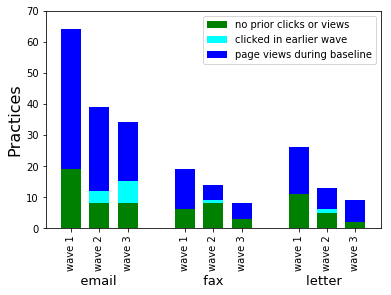

In [25]:
# create chart

import matplotlib.pyplot as plt

ind = np.r_[ 0:3, 4:7, 8:11 ]     # the x locations for the groups
width = 0.7       # the width of the bars

p1 = plt.bar(ind, data["no prior clicks"], width, color='green')
p2 = plt.bar(ind, data["prior click"], width, bottom=data["no prior clicks"], color='cyan')
p3 = plt.bar(ind, data["prior views"], width, bottom=data["no prior clicks"]+data["prior click"], color='blue')

plt.ylabel('Practices', size=16)
plt.yticks(np.arange(0, 80, 10),size=10)

plt.xticks(ind, ('wave 1', 'wave 2', 'wave 3','wave 1', 'wave 2', 'wave 3','wave 1', 'wave 2', 'wave 3'),size=10, rotation='vertical')
plt.xlabel('   email                     fax                    letter    ', size=13)

plt.legend((p1[0], p2[0], p3[0]), ("no prior clicks or views","clicked in earlier wave","page views during baseline"),fontsize=10)


plt.show()

## Outcome: Number of practices accessing at least one link provided in the intervention, as a proportion of all practices contacted, for group A versus B

In [26]:
c3 = results.copy().loc[(results.group_ab!="con")&(results.sent>0)&(results.Pageviews>0)]

# count how many practices had at least one link accessed
c3 = c3.groupby(['group_ab', 'wave' ]).practice_id.nunique().unstack().fillna(0)
# note 'wave' indicates whch intervention link was accessed, therefore separates by wave

c3a = results.copy().loc[(results.group_ab!="con")&(results.sent>0)&(results.Pageviews>0)] # exclude practices not contacted
c3a = pd.DataFrame(c3a.groupby(['group_ab']).practice_id.nunique().fillna(0).rename("all_waves"))
c3b = pd.concat([c3,c3a],axis=1)

# denominator: practices in each group which were successfully contacted:
c3d = results.groupby(["group_ab","wave"])["practice_id"].nunique().unstack() 
c3d = pd.concat([c3d,prac.merge(cont[["practice_id"]], on="practice_id").groupby(["group_ab"])["practice_id"].nunique().rename("all_waves_d")],axis=1).drop("con")
c3d.rename(columns={1:"1d",2:"2d",3:"3d"}, inplace=True)

c3b = pd.concat([c3b,c3d],axis=1)
# calculate rates
c3b['all_waves -'] = c3b["all_waves_d"]-c3b["all_waves"]
c3b['all_waves rate'] = c3b["all_waves"]/c3b["all_waves_d"]

c3b = c3b.drop(["all_waves_d"],axis=1)
c3b


C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,1,2,3,all_waves,1d,2d,3d,all_waves -,all_waves rate
group_ab,,,,,,,,,
A,54,30,30,93,356,356,356,263.0,0.261236
B,47,34,20,85,347,347,347,262.0,0.244957


### Statistical test

**Primary and secondary outcomes measured as proportions will be compared with confidence intervals (CIs) and chi-squared tests**


In [27]:
obs = np.array(c3b[["all_waves","all_waves -"]]) # taking the number accessed from any wave and the number never accessed
 
print(obs)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d, 'confidence intervals: ',ci1)

[[  93.  263.]
 [  85.  262.]]
chi2 =  0.167706949733 ; p =  0.682157806514
difference in proportion:  0.0162791827219 confidence intervals:  (-0.047987218660088232, 0.080545584103859952)


**Wave 1 only (not prespecified)**

In [28]:
c3b["1-"] = c3b["1d"] - c3b[1]
obs = np.array(c3b[[1,"1-"]]) # taking the number accessed from any wave and the number never accessed
 
print(obs)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d, 'confidence intervals: ',ci1)

[[ 54 302]
 [ 47 300]]
chi2 =  0.256207317972 ; p =  0.612737833993
difference in proportion:  0.0162387073795 confidence intervals:  (-0.03557794648377946, 0.068055361242708362)


## Outcome: Number of links accessed at least once as a proportion of all links delivered by each method of contact (email, fax, letter).
** NB. best restricted to just wave 1 because results in subsequent waves not independent**

In [29]:
views = results.copy().loc[(results.group_ab!="con")&(results.wave==1)]
views = views[['practice_id','Unique Pageviews','medium']]
views = views.sort_values(['practice_id','medium'])
views['Unique Pageviews'] = True
views.head()

,practice_id,Unique Pageviews,medium
8,A81016,True,e
4211,A81016,True,f
8414,A81016,True,p
10,A81030,True,e
4213,A81030,True,f


**Statistical test**

For the proportion of links accessed by each method of contact, a McNemar paired-sample test will be used, because these measurements are not independent, e.g. a practice using the link supplied by email may be less likely to access the link in the
letter.

In [30]:
import statsmodels.sandbox.stats.runs as models

sent = prac.copy().merge(cont[["practice_id","medium","wave","delivery_success"]], on="practice_id")
sent = sent.loc[sent['wave']==1]
sent = sent[['practice_id','medium']]

views = results.copy().loc[(results.group_ab!="con")&(results.sent>0)&(results.wave==1)&(results.Pageviews>0)]
views = views[['practice_id','Unique Pageviews','medium']]
views = views.sort_values(['practice_id','medium'])
views['Unique Pageviews'] = True

table = sent.copy().merge(views, how='left', on = ['practice_id','medium'])
table = table.set_index(['practice_id','medium'])
table = table.fillna(False)
print(table.unstack().agg(["sum","count"]))
      
table = table.unstack()
table.columns = table.columns.droplevel()



for a in [['e','f'],['e','p'],['f','p']]:
    neither = ~table[a[0]]&~table[a[1]]
    neither = neither.sum()
    one = table[a[0]]&~table[a[1]]
    one = one.sum()
    two = ~table[a[0]]&table[a[1]]
    two = two.sum()
    both = table[a[0]]&table[a[1]]
    both = both.sum()
    test_2x2 = [[neither,one],[two,both]]
    print(a)
    print(pd.DataFrame(test_2x2))
    print(models.mcnemar(test_2x2))



      Unique Pageviews          
                     e    f    p
sum                 64   19   26
count              703  703  703
['e', 'f']
     0   1
0  622  62
1   17   2
(17, 3.588358881586288e-07)
['e', 'p']
     0   1
0  617  60
1   22   4
(22, 3.2317126198897567e-05)
['f', 'p']
     0   1
0  661  16
1   23   3
(16, 0.33678363518993137)


### Sensitivity analysis


We will also perform a sensitivity analysis where we restrict analysis to only practices contacted by all three methods, to assess bias, e.g. practices with a discoverable fax number may be less responsive to email.


**- Filter to practices only accessing links via all 3 methods**

**- limit to wave 1**

In [31]:
sent = prac.merge(cont[["practice_id","medium","wave","sent"]], on="practice_id")
sent = sent.loc[(sent['wave']==1)&(sent.group_ab!="con")]

all3 = pd.DataFrame(sent.groupby(["practice_id"])["sent"].sum().rename("mediums"))
all3 = all3.loc[all3["mediums"]==3].reset_index().drop("mediums",axis=1)

sent = sent.merge(all3, on="practice_id",how="inner")

sent = sent[['practice_id','medium']]
print (sent.practice_id.nunique(), "practices received all 3 interventions after wave 1.")

views = results.copy().loc[(results.group_ab!="con")&(results.sent>0)&(results.wave==1)&(results.Pageviews>0)]
views = views[['practice_id','Unique Pageviews','medium']]
views = views.sort_values(['practice_id','medium'])
views['Unique Pageviews'] = True

table = sent.copy().merge(views, how='left', on = ['practice_id','medium'])
table = table.set_index(['practice_id','medium'])
table = table.fillna(False)
print(table.unstack().agg(["sum","count"]))
      
table = table.unstack()
table.columns = table.columns.droplevel()

for a in [['e','f'],['e','p'],['f','p']]:
    neither = ~table[a[0]]&~table[a[1]]
    neither = neither.sum()
    one = table[a[0]]&~table[a[1]]
    one = one.sum()
    two = ~table[a[0]]&table[a[1]]
    two = two.sum()
    both = table[a[0]]&table[a[1]]
    both = both.sum()
    test_2x2 = [[neither,one],[two,both]]
    print(a)
    print(pd.DataFrame(test_2x2))
    print(models.mcnemar(test_2x2))


682 practices received all 3 interventions after wave 1.
      Unique Pageviews          
                     e    f    p
sum                 63   19   25
count              682  682  682
['e', 'f']
     0   1
0  602  61
1   17   2
(17, 5.6637396254182366e-07)
['e', 'p']
     0   1
0  598  59
1   21   4
(21, 2.5291102564670619e-05)
['f', 'p']
     0   1
0  641  16
1   22   3
(16, 0.41769219083653242)


### Display results table to detail links accessed: by wave, medium and group A/B

In [32]:
sent = prac.copy().merge(cont[["practice_id","medium","wave","delivery_success"]], on="practice_id")
sent2 = sent[['practice_id','group_ab','medium',"wave","delivery_success"]]
sent = sent[['practice_id','medium']]

views = results.copy().loc[(results.group_ab!="con")&(results.sent>0)&(results.Pageviews>0)]
views = views[['practice_id','Unique Pageviews','medium','wave',"group_ab"]]
views['Unique Pageviews'] = True

table = sent.copy().merge(views, how='left', on = ['practice_id','medium'])

table.groupby(['wave','group_ab','medium'])['practice_id'].agg(["nunique","count"]).unstack()

nunique         count        
medium              e   f   p     e   f   p
wave group_ab                              
1.0  A             35  11  12   105  33  36
     B             29   8  14    87  24  42
2.0  A             17   7   8    51  21  24
     B             22   7   5    66  21  15
3.0  A             20   4   7    60  12  21
     B             15   4   2    45  12   6

In [33]:
sent2.groupby(['wave','group_ab','medium','delivery_success'])['practice_id'].nunique().unstack().unstack()

delivery_success   0.0                 1.0           
medium               e     f      p      e      f   p
wave group_ab                                        
1    A             5.0  14.0  356.0  351.0  342.0 NaN
     B            18.0  25.0  347.0  329.0  322.0 NaN
2    A            17.0  26.0  356.0  339.0  330.0 NaN
     B            33.0  35.0  347.0  314.0  312.0 NaN
3    A            27.0  29.0  356.0  329.0  327.0 NaN
     B            38.0  38.0  347.0  309.0  309.0 NaN

### Add summary columns to table...

In [34]:
table.groupby(['wave','group_ab'])['practice_id'].agg(["nunique","count"])

nunique  count
wave group_ab                
1.0  A              54    174
     B              47    153
2.0  A              30     96
     B              34    102
3.0  A              30     93
     B              20     63

In [35]:
table.groupby(['group_ab'])['practice_id'].agg(["nunique","count"])

,nunique,count
group_ab,,
A,93,363
B,85,318


In [36]:
table.loc[table['Unique Pageviews']==True].groupby(['medium'])['practice_id'].agg(["nunique","count"])
#table.head()

,nunique,count
medium,,
e,109,414
f,38,123
p,45,144


# Subgroup analyses

## Comparison of engagement from purchased versus freely available email addresses. 

In [37]:
p = pd.read_csv('data/practice_details_purchased.csv')

# filter engagement data to intervention practices where an email was sent by email
emails = results.loc[(results.medium=="e")&(results.group_ab!="con")&(results.sent>0)] 

# merge engagement data to list of practices where an email was successfully obtained commercially
p2 = emails.merge(p.loc[p.Email == True],on=["practice_id"],how="left").fillna(False)
p2.head()

,medium,wave,Unnamed: 0,practice_id,ccg_id,baseline,baseline_ranking,allocation,group_ab,Pageviews,Unique Pageviews,sent,delivery_success,Email,Fax
0,e,1,0,A83060,00D,0.110106,0.840377,I,A,0.0,0.0,1.0,1.0,False,False
1,e,1,2,A83050,00J,0.109578,0.836808,I,A,1.0,1.0,1.0,1.0,True,False
2,e,1,4,A84007,00L,0.107757,0.822530,I,A,4.0,4.0,1.0,1.0,True,True
3,e,1,6,A84032,00L,0.125352,0.919475,I,B,0.0,0.0,1.0,1.0,False,False
4,e,1,7,A81016,00M,0.113095,0.861936,I,A,0.0,0.0,1.0,0.0,True,False


In [38]:
# group data across all waves to find where any email link was accessed for each practice
p3 = pd.DataFrame(p2.groupby(["practice_id","medium","Email"])["Pageviews"].max())
p3.loc[(p3.Pageviews>0),"viewed"] = True  #convert the max pageviews into binary
p3 = p3.fillna("False").reset_index()

p3.head()

,practice_id,medium,Email,Pageviews,viewed
0,A81016,e,True,0.0,False
1,A81030,e,True,1.0,True
2,A81051,e,True,0.0,False
3,A81052,e,False,0.0,False
4,A81054,e,True,0.0,False


In [39]:
# count number of practices viewing any of the links supplied by email, split into those commercially obtained or not
p4 = p3.groupby(["viewed","Email"])["practice_id"].count().unstack()

# append the sum of practices in each group and calculate percentage
p4 = p4.append(pd.Series(p4.sum(),name="total"))
p4.append(pd.Series((100*p4.loc[True]/p4.loc["total"]).round(1),name="percent"))

Email,False,True
viewed,,
True,23.0,86.0
False,188.0,388.0
total,211.0,474.0
percent,10.9,18.1


**Statistical test**

In [40]:
p5 = p4.copy().rename(columns={True:"true", False:"false"})
p5 = p5[["true","false"]].iloc[[0,1]].transpose()
obs = np.array(p5) 

print(obs)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d, 'confidence intervals: ',ci1)

[[ 86 388]
 [ 23 188]]
chi2 =  5.1959836736 ; p =  0.0226391388257
difference in proportion:  0.0724298598196 confidence intervals:  (0.017914290717140763, 0.12694542892210975)


# Contamination

## Number of non-intervention practices having their OpenPrescribing.net pages viewed during sessions arising from links being clicked. 
This could either arise from participants observing other practices’ behaviour after their own, or sharing the links with others who then look for their own practice.

In [41]:
print (c2.loc[c2.allocation=="con"].practice_id.nunique(), " practices in control group.")
print ("Of which ",c2.loc[(c2.allocation=="con") & (c2.Pageviews > 0)].practice_id.nunique(), 
       " had dashboard viewed during a session initiated by an intervention.")

698  practices in control group.
Of which  3  had dashboard viewed during a session initiated by an intervention.


## Links accessed by multiple users

Data extraction:
 - Behaviour -> site content -> content drilldown
 - Segment: rct1 - wave 1
 - Select '/practice/' to show Page path level 2
 - Secondary dimension: User Bucket ("Randomly assigned users tag to allow A/B testing and splitting of memarketing lists. Ranges from 1-100.")
 - Date range: 6/5/2018-6/8/2018 (this is the maximum allowed with a segment)
 
 - Ensure all rows of data are visible before extraction, and top rows must be removed from the csv before loading. 


In [42]:
share = pd.read_csv('data/contamination_wave1_20180506_20180806.csv')
share = share.rename(columns={"Page path level 2":"page"})

share2 = pd.read_csv('data/contamination_wave2_20180611_20180828.csv')
share2 = share2.rename(columns={"Page path level 2":"page"})

share2.head()

,page,User Bucket,Pageviews,Unique Pageviews,Avg. Time on Page,Bounce Rate,% Exit
0,/J82605/,100,1,1,00:00:46,0.00%,0.00%
1,/,98,5,1,00:03:55,0.00%,20.00%
2,/C82077/,98,5,3,00:01:18,0.00%,0.00%
3,/C83074/,98,1,1,00:01:04,0.00%,0.00%
4,/,91,1,1,00:00:11,0.00%,0.00%


In [43]:
s2 = pd.DataFrame(share.loc[share.page.str.len()==8].groupby('page')["User Bucket"].nunique()).reset_index()
s2 = s2.rename(columns={"User Bucket":"users"})
s2.head()

,page,users
0,/A83050/,1
1,/A84007/,2
2,/A86020/,1
3,/A89007/,1
4,/B81656/,1


In [44]:
s2 = s2.groupby('users').count().reset_index()
s2["percent"] = (100*s2["page"]/s2["page"].sum()).round(1)
s2

,users,page,percent
0,1,78,72.9
1,2,20,18.7
2,3,5,4.7
3,4,1,0.9
4,5,2,1.9
5,10,1,0.9


In [45]:
s2 = pd.DataFrame(share2.loc[share2.page.str.len()==8].groupby('page')["User Bucket"].nunique()).reset_index()
s2 = s2.rename(columns={"User Bucket":"users"})
s2 = s2.groupby('users').count().reset_index()
s2["percent"] = (100*s2["page"]/s2["page"].sum()).round(1)
s2

,users,page,percent
0,1,51,77.3
1,2,6,9.1
2,3,7,10.6
3,4,2,3.0


## Exploratory analysis of browsing by medium

In [46]:
browsing.head()

,Page,Pageviews,Unique Pageviews,Avg. Time on Page,Bounce Rate,medium,practice_id,wave
0,/practice/L81004/,15,11,00:01:36,63.64%,p,L81004,1
6,/practice/F85634/,12,3,00:00:44,100.00%,p,F85634,1
15,/practice/L82058/#ktt9_cephalosporins,9,7,00:03:12,50.00%,e,L82058,1
18,/practice/Y02506/#ktt9_cephalosporins,8,2,00:01:43,0.00%,f,Y02506,1
20,/practice/Y02506/#ktt9_cephalosporins,8,2,00:01:43,0.00%,f,Y02506,3


In [47]:
b = browsing.copy().rename(columns={"Avg. Time on Page":"time"})
b.head()

,Page,Pageviews,Unique Pageviews,time,Bounce Rate,medium,practice_id,wave
0,/practice/L81004/,15,11,00:01:36,63.64%,p,L81004,1
6,/practice/F85634/,12,3,00:00:44,100.00%,p,F85634,1
15,/practice/L82058/#ktt9_cephalosporins,9,7,00:03:12,50.00%,e,L82058,1
18,/practice/Y02506/#ktt9_cephalosporins,8,2,00:01:43,0.00%,f,Y02506,1
20,/practice/Y02506/#ktt9_cephalosporins,8,2,00:01:43,0.00%,f,Y02506,3


In [48]:
pages = b.groupby("medium")["Page"].agg({"count","nunique"})

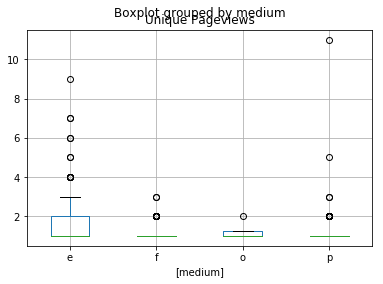

,count,mean,std,min,25%,50%,75%,max
medium,,,,,,,,
e,113.0,3.646018,3.602877,1.0,1.0,3.0,4.0,22.0
f,42.0,2.261905,1.562667,1.0,1.0,2.0,3.0,7.0
o,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
p,49.0,3.244898,3.269369,1.0,1.0,2.0,4.0,16.0


In [49]:
sess = b.loc[b.Page.str.len()==17]
sess = b.groupby(["practice_id","medium"])["Unique Pageviews"].sum()
boxplot = b[["medium","Unique Pageviews"]].boxplot(by='medium')
plt.show()
sess.groupby("medium").describe()

In [50]:
# create numeric field from bounce rate field:
b["bounce"] = b["Bounce Rate"].str[:-1].astype("float")/100
b["n_bounce"] = b.bounce*b["Unique Pageviews"]

# convert time field to number of seconds:
b["hrs"] = b.time.str[:2].astype("int")
b["mins"] = b.time.str[3:5].astype("int")
b["secs"] = b.time.str[6:].astype("int")
b["total_time"] = b["hrs"]*60*60 + b["mins"]*60+b["secs"]
b = b.loc[b.medium!="o"]

b.groupby("medium")["bounce"].describe()

,count,mean,std,min,25%,50%,75%,max
medium,,,,,,,,
e,266.0,0.346253,0.450160,0.0,0.0,0.0,1.0,1.0
f,78.0,0.153846,0.354083,0.0,0.0,0.0,0.0,1.0
p,122.0,0.167102,0.364328,0.0,0.0,0.0,0.0,1.0


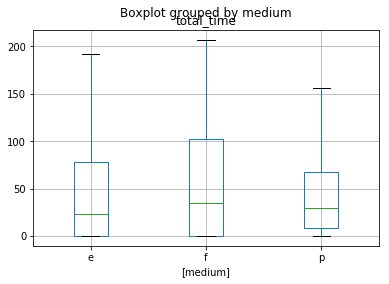

,count,mean,std,min,25%,50%,75%,max
medium,,,,,,,,
e,266.0,79.849624,175.306072,0.0,0.00,23.0,78.50,1281.0
f,78.0,107.038462,194.972022,0.0,0.00,35.0,102.75,1077.0
p,122.0,54.163934,69.413167,0.0,8.25,30.0,67.75,334.0


In [51]:
boxplot = b[["medium","total_time"]].boxplot(by='medium', showfliers=False)
plt.show()
b.groupby("medium")["total_time"].describe()

# Questionnaire analysis (not prespecified)

In [52]:
# load questionnaire results data:
qdb = pd.read_csv('data/questionnaire_report.csv').fillna(-1) 
# 1= yes, 0=no
# nulls are filled with -1 to indicate no response

# count responses for each group
a1 = prac.loc[prac['allocation']!="con"].merge(qdb, on="practice_id", how="left")
a2 = pd.DataFrame(a1.groupby(['group_ab','answer'])['practice_id'].nunique())
# totals:
a3 = pd.DataFrame(a1.groupby(['group_ab'])['practice_id'].nunique()).reset_index().rename(columns={"practice_id":"total"})

a2

practice_id
group_ab answer             
A        -1.0            266
          0.0             28
          1.0             62
B        -1.0            265
          0.0             23
          1.0             59

In [53]:
# comine grouped and total figues to create results table
a4 = a2.unstack()
a4.columns = a4.columns.droplevel()
a4 = a4.reset_index().merge(a3, on="group_ab").rename(columns={-1:"no response",0:"no",1:"yes"})

a4 = a4.append(a4.sum(),ignore_index=True)
a4

,group_ab,no response,no,yes,total
0,A,266,28,62,356
1,B,265,23,59,347
2,AB,531,51,121,703


In [54]:
a4["% response rate"] = (100*(a4.total-a4["no response"])/a4.total).round(1)
a4["% responding yes"] = (100*a4.yes/(a4.no+a4.yes)).round(1)

a4


,group_ab,no response,no,yes,total,% response rate,% responding yes
0,A,266,28,62,356,25.3,68.9
1,B,265,23,59,347,23.6,72.0
2,AB,531,51,121,703,24.5,70.3


## Practices answering "yes" versus "no"

In [55]:
q_pracs = a1.loc[a1.answer!=-1].reset_index()
q_pracs = q_pracs[["practice_id","answer"]]
q_pracs.head()

,practice_id,answer
0,A83050,0.0
1,A81030,0.0
2,A89007,0.0
3,P81082,0.0
4,P85006,1.0


In [56]:
pvs = pd.read_csv('data/pageviews_wave123.csv')
pvs

,Page,Medium,Date Range,Segment,Pageviews,Unique Pageviews,Avg. Time on Page,Entrances,Bounce Rate,% Exit,Page Value
0,/practice/L81004/,post - ktt9_cephalosporins,"May 7, 2018 - Aug 7, 2018",rct1 - wave 1,15,11,00:01:36,11,63.64%,66.67%,$0.91
1,/practice/L81004/,post - ktt9_cephalosporins,"May 7, 2018 - Aug 7, 2018",rct1 - wave2,0,0,00:00:00,0,0.00%,0.00%,$0.00
2,/practice/L81004/,post - ktt9_cephalosporins,"May 7, 2018 - Aug 7, 2018",rct1 - wave3,0,0,00:00:00,0,0.00%,0.00%,$0.00
3,/measure/ktt9_cephalosporins/,email,"May 7, 2018 - Aug 7, 2018",rct1 - wave 1,14,14,00:02:39,2,100.00%,50.00%,$5.00
4,/measure/ktt9_cephalosporins/,email,"May 7, 2018 - Aug 7, 2018",rct1 - wave2,9,8,00:00:50,1,100.00%,44.44%,$3.75
5,/measure/ktt9_cephalosporins/,email,"May 7, 2018 - Aug 7, 2018",rct1 - wave3,3,2,00:03:47,0,0.00%,0.00%,$10.00
6,/practice/F85634/,post,"May 7, 2018 - Aug 7, 2018",rct1 - wave 1,12,3,00:00:44,1,100.00%,16.67%,$0.00
7,/practice/F85634/,post,"May 7, 2018 - Aug 7, 2018",rct1 - wave2,0,0,00:00:00,0,0.00%,0.00%,$0.00
8,/practice/F85634/,post,"May 7, 2018 - Aug 7, 2018",rct1 - wave3,0,0,00:00:00,0,0.00%,0.00%,$0.00
9,/measure/ktt9_cephalosporins/,post,"May 7, 2018 - Aug 7, 2018",rct1 - wave 1,9,7,00:01:20,0,0.00%,33.33%,$5.71


In [57]:
## Assess primary outcome measure between those answering "yes" versus "no"

# define aggregations
aggregations = {
    'practice_id': { # work on the "practice_id" column
        'Count': 'count'},
    'Pageviews_before': {     
        'Distinct pages': 'count'},
    'Pageviews_after': {     
        'Distinct pages': 'count'},
    'proxy_pageviews_before': {
        'Mean': 'mean',
        'StDev': 'std',
        'Max': 'max',
        'Median': 'median'},
    'proxy_pageviews_after': {
        'Mean': 'mean',
        'StDev': 'std',
        'Max': 'max',
        'Median': 'median'}
}

# Perform groupby aggregation for intervention vs control

yn = q_pracs.merge(m2, how='left', on='practice_id')
yn = yn.groupby(["answer"]).agg(aggregations)

yn = yn.rename(columns={'proxy_pageviews_before': 'Page Views per Page (Before)', 'Pageviews_after':'Pages viewed After','Pageviews_before':'Pages viewed Before','proxy_pageviews_after': 'Page Views per Page (After)','practice_id':'Practices'}) 
yn["Pages viewed Before","%"] = (100*yn['Pages viewed Before','Distinct pages']/yn['Practices','Count']).round(1)
yn["Pages viewed After","%"] = (100*yn['Pages viewed After','Distinct pages']/yn['Practices','Count']).round(1)
yn = yn.sort_index(axis=1)

yn2 = yn[['Practices','Pages viewed Before','Pages viewed After']].sort_index(ascending=False)
#yn["change from baseline"] = yn["follow-up"]["percent_viewed_follow-up"] - yn["baseline"]["percent_viewed_baseline"]


yn2

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Practices Pages viewed Before                Pages viewed After  \
           Count                   % Distinct pages                  %   
answer                                                                   
1.0          121                59.5             72               80.2   
0.0           51                70.6             36               86.3   

                       
       Distinct pages  
answer                 
1.0                97  
0.0                44

In [58]:
from scipy.stats import chi2_contingency

s1 = pd.DataFrame(yn2.iloc[:,[0,4]]).reset_index()
s1.columns = s1.columns.droplevel()
s1["Not viewed"] = s1["Count"]-s1["Distinct pages"]
obs = np.array(s1[["Distinct pages","Not viewed"]])
 
print(s1)
    
chi2, p, dof, ex = chi2_contingency(obs)
print ("chi2 = ", chi2, "; p = ", p)

def diffprop(obs):
    n1, n2 = obs.sum(axis=1)
    prop1 = obs[0,0] / n1
    prop2 = obs[1,0] / n2
    delta = prop1 - prop2

    # Wald 95% confidence interval for delta
    se = np.sqrt(prop1*(1 - prop1)/n1 + prop2*(1 - prop2)/n2)
    ci = (delta - 1.96*se, delta + 1.96*se)

    # Yates continuity correction for confidence interval of delta
    correction = 0.5*(1/n1 + 1/n2)
    corrected_ci = (ci[0] - correction, ci[1] + correction)

    return delta, ci, corrected_ci

d, ci1, ci2 = diffprop(obs)
print ('difference in proportion: ', d.astype(float).round(4), 'confidence intervals: ',ci1)

        Count  Distinct pages  Not viewed
0  1.0    121              97          24
1  0.0     51              44           7
chi2 =  0.539980494146 ; p =  0.46244081042
difference in proportion:  -0.0611 confidence intervals:  (-0.1792783777791753, 0.057093966824710768)


## Pages viewed per practice for "yes" versus "no"

In [59]:
yn = q_pracs.merge(m2, how='left', on='practice_id')
print(yn.groupby('answer')[('proxy_pageviews_before','proxy_pageviews_after')].mean())
yn6 = yn[['practice_id','answer','proxy_pageviews_before','proxy_pageviews_after']]

import statsmodels.formula.api as smf
data = yn6

lm = smf.ols(formula='data["proxy_pageviews_after"] ~ data["proxy_pageviews_before"] +answer', data=data).fit()

lm.summary()


        proxy_pageviews_before  proxy_pageviews_after
answer                                               
0.0                   1.549020               2.137255
1.0                   1.752066               2.512397


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     data["proxy_pageviews_after"]   R-squared:                       0.113
Model:                                       OLS   Adj. R-squared:                  0.102
Method:                            Least Squares   F-statistic:                     10.75
Date:                           Thu, 06 Feb 2020   Prob (F-statistic):           4.04e-05
Time:                                   17:05:57   Log-Likelihood:                -374.47
No. Observations:                            172   AIC:                             754.9
Df Residuals:                                169   BIC:                             764.4
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.5853      0.325      4.873      0.000       0.943       2.228
data["proxy_pageviews_before"]     0.3563      0.079      4.517      0.000       0.201       0.512
answer                             0.3028      0.360      0.841      0.401      -0.408       1.013
==============================================================================
Omnibus:                       41.512   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.914
Skew:                           1.230   Prob(JB):                     1.09e-15
Kurtosis:                       4.888   Cond. No.                         7.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Emails and faxes undelivered

In [60]:
undeliv = prac.merge(cont[["practice_id","medium","wave","sent","delivery_success"]].loc[(cont.sent==1)&(cont.delivery_success==0)], on="practice_id") 
undeliv.groupby(["medium","wave","group_ab"])["delivery_success"].count().unstack() 

group_ab       A    B
medium wave          
e      1       1    4
       2      10   18
       3      13   20
f      1      13   23
       2      22   32
       3      22   33
p      1     356  347
       2     356  347
       3     356  347

# Emails opened

In [61]:
op = pd.read_csv('data/emails_opened.csv')
op.head()

,practice_id,wave
0,A84007,1
1,A89007,1
2,B86007,1
3,C81028,1
4,C82042,1


In [62]:
op["open"] = "opened"
op2 = prac.merge(cont[["practice_id","medium","wave","sent","delivery_success"]].loc[(cont.sent==1)&(cont.medium=="e")&(cont.delivery_success!=0)], on="practice_id") 
op3 = op2.merge(op,on=["practice_id","wave"], how="left")
op3["open"].fillna("no", inplace=True)
op_ab = op3.groupby(["wave","group_ab","open"])["practice_id"].count().unstack()
op_ab

open            no  opened
wave group_ab             
1    A         257      94
     B         268      61
2    A         253      86
     B         253      61
3    A         272      57
     B         262      47

In [63]:

tmp2 = pd.Series(op_ab.sum(axis=0),name="total")
op_ab2 = op_ab.reset_index().append(tmp2).fillna("all")

op_ab2["total"] = op_ab2.no+op_ab2.opened
op_ab2["percent"] = (100*op_ab2.opened / op_ab2.total).round(1)
op_ab3 = op_ab2.drop("no", axis=1)#.set_index(["wave","group_ab"])
op_ab3

open,wave,group_ab,opened,total,percent
0,1,A,94.0,351.0,26.8
1,1,B,61.0,329.0,18.5
2,2,A,86.0,339.0,25.4
3,2,B,61.0,314.0,19.4
4,3,A,57.0,329.0,17.3
5,3,B,47.0,309.0,15.2
total,all,all,406.0,1971.0,20.6


In [64]:
email = results.copy().loc[(results.group_ab!="con")&(results.medium=="e")&(results.Pageviews>0)].groupby(["wave","group_ab"])["practice_id"].nunique()
email = pd.DataFrame(email).reset_index().rename(columns={"practice_id":"link access"})


email.sum()

wave               12
group_ab       ABABAB
link access       138
dtype: object

In [65]:
op_ab.reset_index()

open,wave,group_ab,no,opened
0,1,A,257,94
1,1,B,268,61
2,2,A,253,86
3,2,B,253,61
4,3,A,272,57
5,3,B,262,47
